# Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, to_date, min, max, concat, lit, year, month, dayofmonth, hour, sum, date_format

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 


# Creating Spark session

In [2]:
spark = SparkSession.builder.appName("PosMonitoring").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 14:35:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Analyzing the dataset 

## Loading and visualizing the dataset

In [3]:
df = spark.read.csv("database_pos.csv", header=True, inferSchema=True)
df.show()

+--------------------+-----------+-------+--------+-------+-------+
|            datetime|Living room|Bedroom|Bathroom|Kitchen|Hallway|
+--------------------+-----------+-------+--------+-------+-------+
|2019-11-01 03:52:...|       NULL|    0.0|    NULL|   NULL|   NULL|
|2019-11-01 04:19:...|       NULL|    1.0|    NULL|   NULL|   NULL|
|2019-11-01 04:21:...|       NULL|    0.0|    NULL|   NULL|   NULL|
|2019-11-01 06:11:...|       NULL|    1.0|    NULL|   NULL|   NULL|
|2019-11-01 06:12:...|       NULL|    0.0|    NULL|   NULL|   NULL|
|2019-11-01 06:14:...|       NULL|    1.0|    NULL|   NULL|   NULL|
|2019-11-01 06:15:...|       NULL|    0.0|    NULL|   NULL|   NULL|
|2019-11-01 06:19:...|       NULL|    1.0|    NULL|   NULL|   NULL|
|2019-11-01 06:21:...|       NULL|    0.0|    NULL|   NULL|   NULL|
|2019-11-01 07:42:...|       NULL|    1.0|    NULL|   NULL|   NULL|
|2019-11-01 07:44:...|       NULL|    0.0|    NULL|   NULL|   NULL|
|2019-11-01 07:44:...|       NULL|   NULL|    NU

## Counting NULL values

In [4]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns[1:]]).show()


+-----------+-------+--------+-------+-------+
|Living room|Bedroom|Bathroom|Kitchen|Hallway|
+-----------+-------+--------+-------+-------+
|      19612|  25317|   22525|  25957|  20530|
+-----------+-------+--------+-------+-------+


# Filling NaN/NULL values 

In [33]:
filled_df = df.fillna(0)
filled_df.show(9)


+--------------------+-----------+-------+--------+-------+-------+
|            datetime|Living room|Bedroom|Bathroom|Kitchen|Hallway|
+--------------------+-----------+-------+--------+-------+-------+
|2019-11-01 03:52:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 04:19:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 04:21:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 06:11:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 06:12:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 06:14:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 06:15:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 06:19:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 06:21:...|        0.0|    0.0|     0.0|    0.0|    0.0|
+--------------------+-----------+-------+--------+-------+-------+


## Time interval analysis 

In [22]:
days = df.withColumn('datetime', to_date(col('datetime'))).select('datetime')

first_day = days.select(min('datetime')).first()[0]
last_day = days.select(max('datetime')).first()[0]

nbr_of_days = days.select('datetime').distinct().count()

print("First day: {:>29}".format(str(first_day)))
print("Last day: {:>30}".format(str(last_day)))
print("Total Number of days: {:>10}".format(str(nbr_of_days)))


First day:                    2019-11-01
Last day:                     2020-02-13
Total Number of days:         99


In [23]:
date_range = pd.date_range(start=first_day, end=last_day, freq='D')
complete_day_range = pd.DataFrame({'datetime': date_range})
complete_day_range = spark.createDataFrame(complete_day_range)
complete_day_range = complete_day_range.withColumn('datetime', to_date(col('datetime'))).select('datetime')

print("Number of days without reading:", complete_day_range.count()-nbr_of_days)


Number of days without reading: 6


## Let's print the missing days 

In [28]:
dates_not_in_second_df = complete_day_range.select("datetime").subtract(days.select("datetime"))
dates_not_in_second_df.show()


+----------+
|  datetime|
+----------+
|2020-01-28|
|2020-01-27|
|2020-02-01|
|2020-01-30|
|2020-01-31|
|2020-02-03|
+----------+


##  Filling the missing days

In [34]:
filled_df = filled_df.join(complete_day_range, "datetime", "full")
filled_df = filled_df.fillna(0)

filled_df.show()


+--------------------+-----------+-------+--------+-------+-------+
|            datetime|Living room|Bedroom|Bathroom|Kitchen|Hallway|
+--------------------+-----------+-------+--------+-------+-------+
| 2019-11-01 00:00:00|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 03:52:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 04:19:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 04:21:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 06:11:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 06:12:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 06:14:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 06:15:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 06:19:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 06:21:...|        0.0|    0.0|     0.0|    0.0|    0.0|
|2019-11-01 07:42:...|        0.0|    1.0|     0.0|    0.0|    0.0|
|2019-11-01 07:44:...|        0.0|    0.0|     0

## Number of values per days

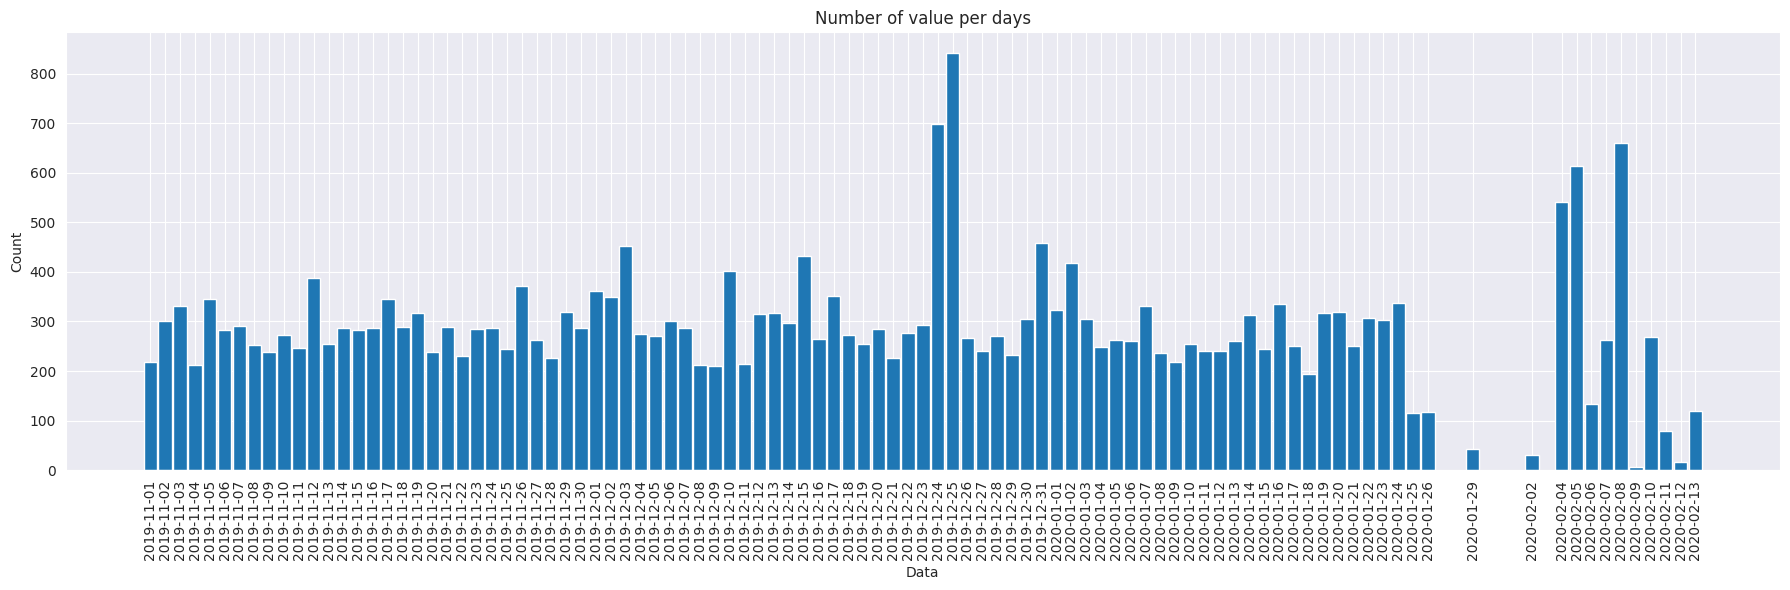

In [35]:
count_per_day = days.groupBy('datetime').agg(count('*').alias('count_per_day'))

count_per_day_df = count_per_day.toPandas()
count_per_day_df = count_per_day_df.sort_values(by='datetime')

plt.figure(figsize=(18, 6))
plt.bar(count_per_day_df['datetime'], count_per_day_df['count_per_day'], width=0.9, align='center')
plt.title('Number of value per days')
plt.xlabel('Data')
plt.ylabel('Count')
plt.xticks(count_per_day_df['datetime'], rotation=90)
plt.tight_layout()
plt.show()


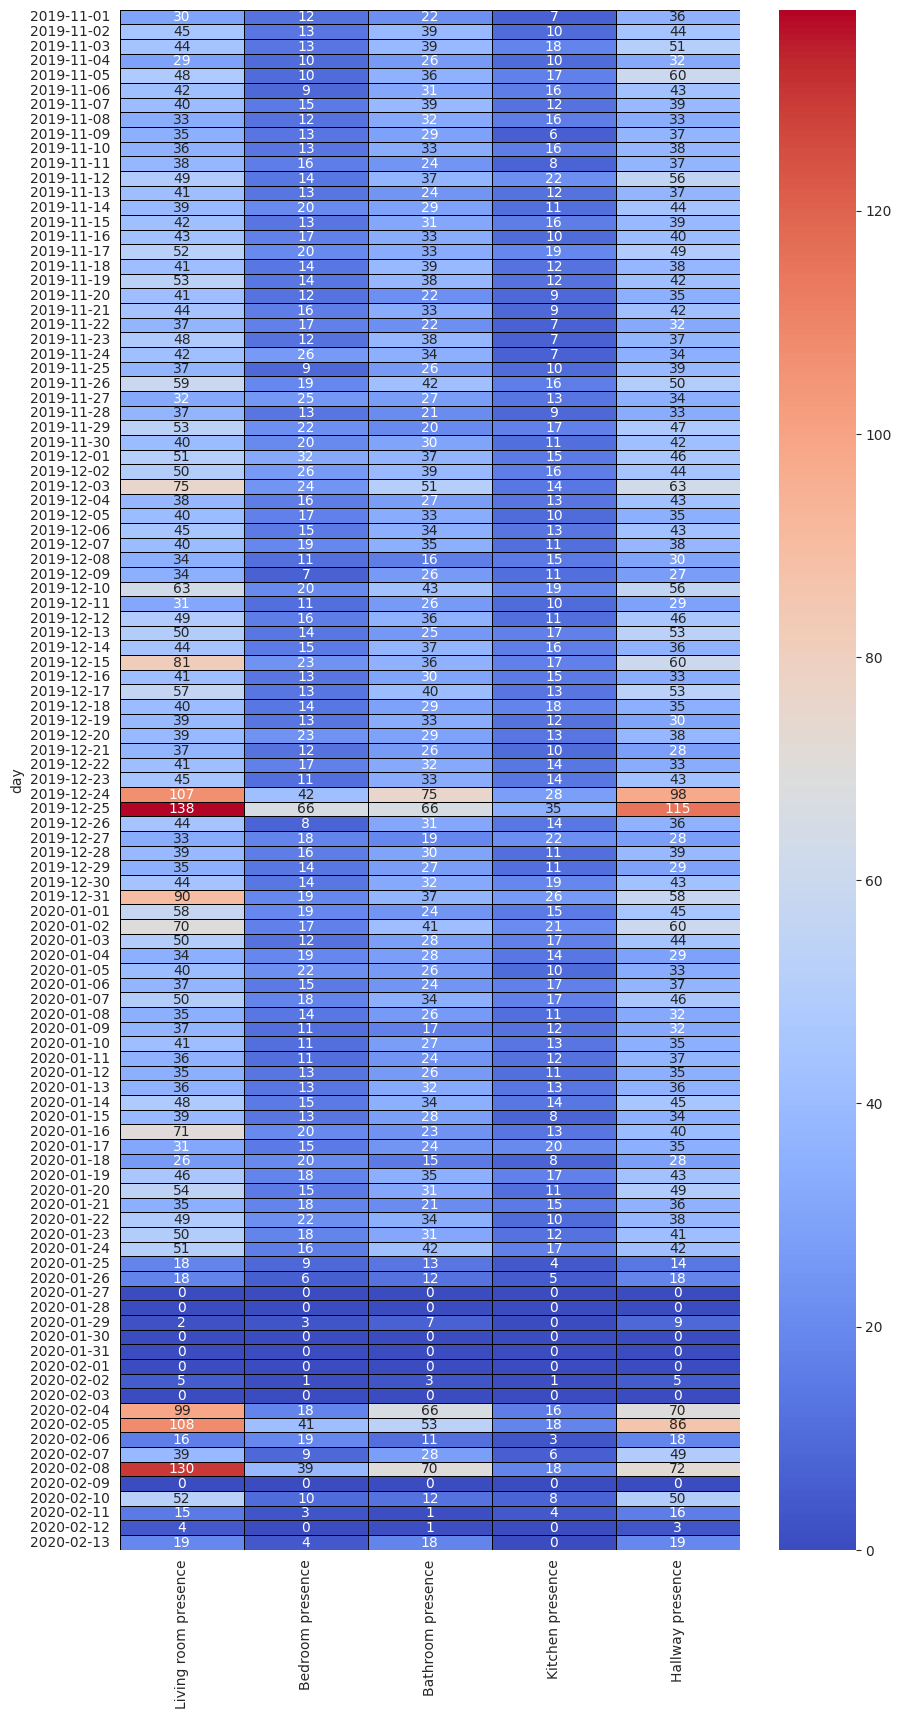

In [39]:
tmp_df = filled_df.withColumn('day', date_format(filled_df['datetime'], 'yyyy-MM-dd'))
tmp_df = tmp_df.drop("datetime")

grouped_df = (tmp_df.groupBy("day").agg( 
        sum((col("Living room") == 1).cast("int")).alias("Living room presence"),
        sum((col("Bedroom") == 1).cast("int")).alias("Bedroom presence"),
        sum((col("Bathroom") == 1).cast("int")).alias("Bathroom presence"),
        sum((col("Kitchen") == 1).cast("int")).alias("Kitchen presence"),
        sum((col("Hallway") == 1).cast("int")).alias("Hallway presence")))

grouped_df = grouped_df.orderBy("day")

room_heatmap = grouped_df.toPandas()
room_heatmap = room_heatmap.sort_index()
room_heatmap.set_index("day", inplace=True)


plt.figure(figsize=(10, 20))  
heatmap = sns.heatmap(room_heatmap, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', fmt="d", annot_kws={"size": 10})
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=10)

plt.show()


## Pairplot

In [ ]:
import seaborn as sns
sns.pairplot(filled_df.toPandas())


## Correlation matrix

In [ ]:
correlation_matrix = filled_df.toPandas().corr()

plt.figure(figsize=(6, 4))  # Imposta le dimensioni della figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # Plot heatmap with correlation values annotated
plt.title('Correlation Matrix')  # Set the title
plt.show()


In [ ]:

tmp_df = filled_df.withColumn("data", concat(year(col("datetime")), lit("-"), 
                                            month(col("datetime")), lit("-"), 
                                            dayofmonth(col("datetime"))))

tmp_df = tmp_df.withColumn("ora", hour(col("datetime")))
tmp_df = tmp_df.drop("datetime")
tmp_df = tmp_df.select("data", "ora", *[col for col in tmp_df.columns[:-2]])
tmp_df = tmp_df.withColumn("sum_of_flags", col("Living room") + col("Bedroom") + col("Bathroom") + col("Kitchen") + col("Hallway"))

tmp_df = tmp_df.groupBy("data", "ora").agg(*[sum(col("sum_of_flags")).alias("sum_of_flags")])
tmp_df = tmp_df.orderBy(col("data"), col("ora"))

tmp_df.show()


In [ ]:
from pyspark.sql.functions import col, concat, lit, year, month, dayofmonth, hour, sum

tmp_df = filled_df.withColumn("data", concat(year(col("datetime")), lit("-"), 
                                            month(col("datetime")), lit("-"), 
                                            dayofmonth(col("datetime"))))

tmp_df = tmp_df.withColumn("ora", hour(col("datetime")))
tmp_df = tmp_df.drop("datetime")
tmp_df = tmp_df.select("data", "ora", *[col for col in tmp_df.columns[:-2]])

tmp_df = tmp_df.withColumn("sum_of_flags", col("Living room") + col("Bedroom") + col("Bathroom") + col("Kitchen") + col("Hallway"))
tmp_df = tmp_df.filter(tmp_df["sum_of_flags"] > 1)
tmp_df.show()
